In [52]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter as gaussf
from astropy.cosmology import Planck18
from skimage.transform import resize

In [53]:
plt.rcParams.update({'font.size':24})

In [54]:
clust_number = 9
snap_number = 104

In [55]:
plot_dir = '/home/rwicker/plots'
if clust_number == 282 :
    X_ray_file = '/data7/NIKA2-300th/rwicker/mock_Xray_maps/ne2_integrated_map_cl0282.fits'
elif clust_number == 9 :
    X_ray_file = '/data7/NIKA2-300th/rwicker/mock_Xray_maps/epic_comb_ima.fits'
SZ_file = f'/data7/NIKA2-300th/rwicker/mock_SZ_maps/CL{clust_number:04d}_snap{snap_number:03d}_{snap_number:03d}000000000001-ra-0-0-0.fits'

In [56]:
if clust_number == 282:
    levels = np.logspace(-4.4, -3, 15)
    vmin = 0.
    vmax = 1e-5
if clust_number == 9:
    levels = np.logspace(-0.5, 1.5, 10)
    vmin = 0.
    vmax = 17.

In [57]:
data_Xray = fits.getdata(X_ray_file)
data_SZ = fits.getdata(SZ_file, ext=4)
print(data_Xray.shape)

(596, 596)


In [58]:
fits.info(X_ray_file)
fits.info(SZ_file)

Filename: /data7/NIKA2-300th/rwicker/mock_Xray_maps/epic_comb_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   (596, 596)   int32   
Filename: /data7/NIKA2-300th/rwicker/mock_SZ_maps/CL0009_snap104_104000000000001-ra-0-0-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Brightness_1mm    1 ImageHDU        44   (197, 197)   float64   
  2  Stddev_1mm    1 ImageHDU        44   (197, 197)   float64   
  3  Nhits_1mm     1 ImageHDU        44   (197, 197)   float64   
  4  Brightness_2mm    1 ImageHDU        44   (197, 197)   float64   
  5  Stddev_2mm    1 ImageHDU        44   (197, 197)   float64   
  6  Nhits_2mm     1 ImageHDU        44   (197, 197)   float64   
  7  Brightness_1    1 ImageHDU        44   (197, 197)   float64   
  8  Stddev_1      1 ImageHDU        44   (197, 197)   float64   
  9  Nhits_1       1 ImageHDU        44   (197, 197)   fl

In [59]:
header_Xray = fits.getheader(X_ray_file)
header_SZ = fits.getheader(SZ_file, ext=4)
r500 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R500']
r200 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R200']
z = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['REDSHIFT']
header_Xray, r500, r200, z, len(data_Xray)

(SIMPLE  =                    T / file does conform to FITS standard             
 BITPIX  =                   32 / number of bits per data pixel                  
 NAXIS   =                    2 / number of data axes                            
 NAXIS1  =                  596 / length of data axis 1                          
 NAXIS2  =                  596 / length of data axis 2                          
 EXTEND  =                    T / FITS dataset may contain extensions            
 XPROC0  = 'evselect table=mos1_c.fits filteredset=filtered.fits withfilteredse&'
 CONTINUE  't=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes &'
 CONTINUE  'dssblock='''' expression=''PI IN [500:2500]'' filtertype=expression&'
 CONTINUE  ' cleandss=no updateexposure=yes filterexposure=yes writedss=yes blo&'
 CONTINUE  'ckstocopy='''' attributestocopy='''' energycolumn=PHA zcolumn=WEIGH&'
 CONTINUE  'T zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignoreleg&'
 CONTINUE  'alli

In [60]:
header_SZ

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  197                                                  
NAXIS2  =                  197                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'Brightness_2mm'                                                      
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '                                                            
CRPIX1  =                   

In [61]:
r500_arcmin = r500/Planck18.kpc_proper_per_arcmin(z).value
r200_arcmin = r200/Planck18.kpc_proper_per_arcmin(z).value
print(r500_arcmin, r200_arcmin)

3.1638853449437425 4.875180263993869


In [62]:
pix_size_Xray = header_Xray['CDELT2']
x_Xray, y_Xray = np.meshgrid(np.linspace(-60 * pix_size_Xray * len(data_Xray)//2, 60 * pix_size_Xray * len(data_Xray)//2, len(data_Xray)),
                   np.linspace(-60 * pix_size_Xray * len(data_Xray)//2, 60 * pix_size_Xray * len(data_Xray)//2, len(data_Xray)))
XMM_resolution = 10/(pix_size_Xray*3600)

In [63]:
#data_Xray = gaussf(data_Xray, XMM_resolution)

/tmp/ipykernel_953975/2088679100.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x_Xray, y_Xray, gaussf(data_Xray,3), levels = levels, colors='k', lw=0.1)


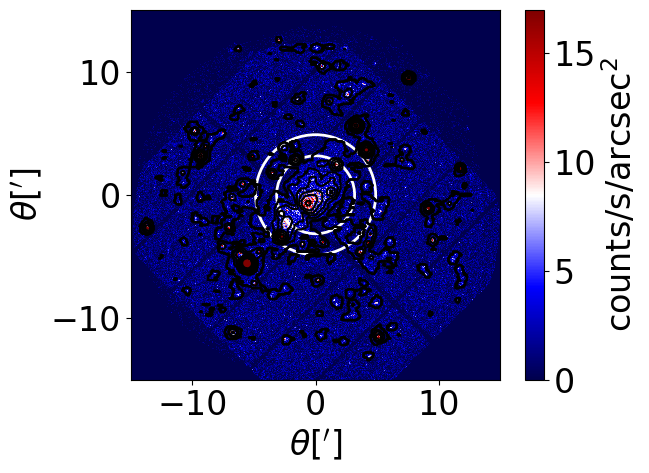

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=2, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=2, color='w')
Xray_map = ax.pcolormesh(x_Xray, y_Xray, data_Xray, cmap='seismic', vmin=vmin, vmax=vmax)
ax.contour(x_Xray, y_Xray, gaussf(data_Xray,3), levels = levels, colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.colorbar(Xray_map, label='counts/s/arcsec$^2$')

plt.savefig(f'{plot_dir}/mock_Xray_CL{clust_number:04d}.png')

In [65]:
pix_size_SZ = header_SZ['CDELT2']
x_SZ, y_SZ = np.meshgrid(np.linspace(-60 * pix_size_SZ * len(data_SZ)//2, 60 * pix_size_SZ * len(data_SZ)//2, len(data_SZ)),
                   np.linspace(-60 * pix_size_SZ * len(data_SZ)//2, 60 * pix_size_SZ * len(data_SZ)//2, len(data_SZ)))
NIKA2_resolution = 12/(pix_size_SZ*3600)

/tmp/ipykernel_953975/3766058355.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x_SZ, y_SZ, gaussf(data_SZ,NIKA2_resolution), levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)


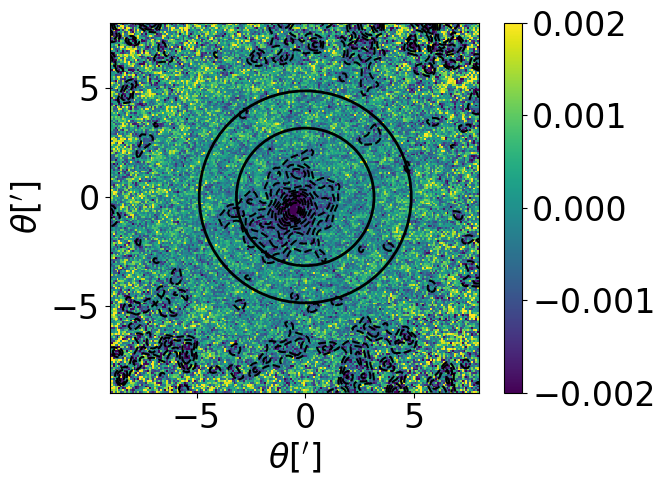

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=2, color='k')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=2, color='k')
SZ_map = ax.pcolormesh(x_SZ, y_SZ, data_SZ, cmap='viridis', vmin=-0.002, vmax=0.002)
ax.contour(x_SZ, y_SZ, gaussf(data_SZ,NIKA2_resolution), levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
plt.colorbar(SZ_map)

plt.savefig(f'{plot_dir}/mock_SZ_CL{clust_number:04d}.png')

# Resize X-ray and SZ maps

In [67]:
pix_size_ratio = pix_size_SZ/pix_size_Xray
pix_size_Xray, pix_size_SZ, pix_size_ratio

(0.00120833333333333, 0.001388888888888889, 1.149425287356325)

In [68]:
#x = np.linspace(0, 196, 197)
#y = np.linspace(0, 196, 197)

#X, Y = np.meshgrid(x, y)  # 2D grid for interpolation

#print(X, Y, (X.shape ,Y.shape))

#interp = interp2d((x, y), data_SZ, method='quintic', bounds_error=False)

#print(interp)

#x2 = np.linspace(0, round(197*pix_size_ratio)-1, round(197*pix_size_ratio))
#y2 = np.linspace(0, round(197*pix_size_ratio)-1, round(197*pix_size_ratio))

#X2,Y2 = np.meshgrid(x2, y2)
#print(X2,Y2, X2.shape)
resampled_SZ = resize(data_SZ, (round(197*pix_size_ratio), round(197*pix_size_ratio)), order=5)
print(resampled_SZ.shape)

(226, 226)


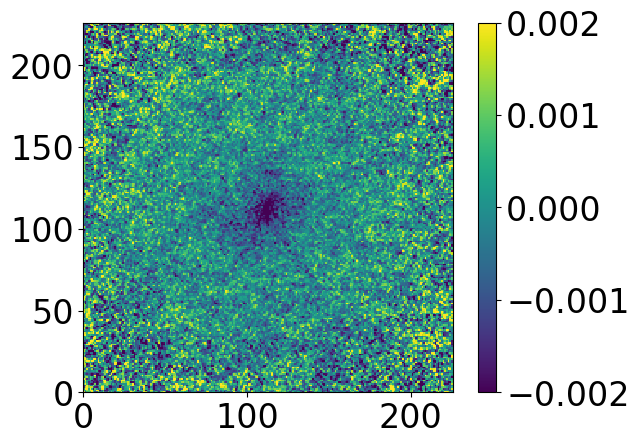

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
resamp_SZ_map = ax.pcolormesh(resampled_SZ, vmin=-0.002, vmax=0.002)
plt.colorbar(resamp_SZ_map)

In [70]:
lower_cropping_lim = len(data_Xray)//2 - len(resampled_SZ)//2
upper_cropping_lim = len(data_Xray)//2 + len(resampled_SZ)//2
cropped_Xray = data_Xray[lower_cropping_lim:upper_cropping_lim, lower_cropping_lim:upper_cropping_lim]

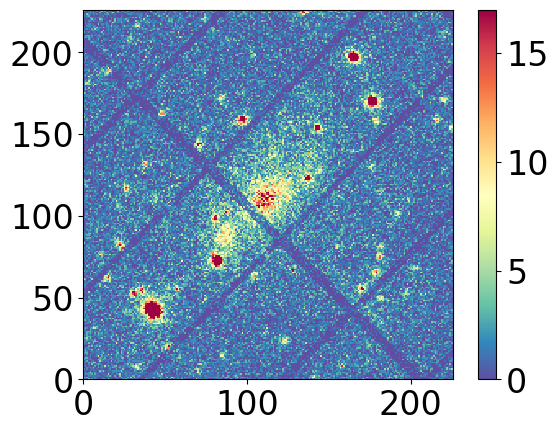

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
cropped_Xray_map = ax.pcolormesh(cropped_Xray, cmap='Spectral_r', vmin=vmin, vmax=vmax)
plt.colorbar(cropped_Xray_map)

# Apply NIKA2 resolution to X-ray and SZ maps

In [72]:
x, y = np.meshgrid(np.linspace(-60 * pix_size_Xray * len(cropped_Xray)//2, 60 * pix_size_Xray * len(cropped_Xray)//2+1, len(cropped_Xray)),
                   np.linspace(-60 * pix_size_Xray * len(cropped_Xray)//2, 60 * pix_size_Xray * len(cropped_Xray)//2+1, len(cropped_Xray)))
NIKA2_resolution = 12/(pix_size_Xray*3600)

/tmp/ipykernel_953975/3287617207.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x,y, gaussf(cropped_Xray,NIKA2_resolution), levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_953975/3287617207.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
  ax1.contour(x,y, gaussf(resampled_SZ,NIKA2_resolution), levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)


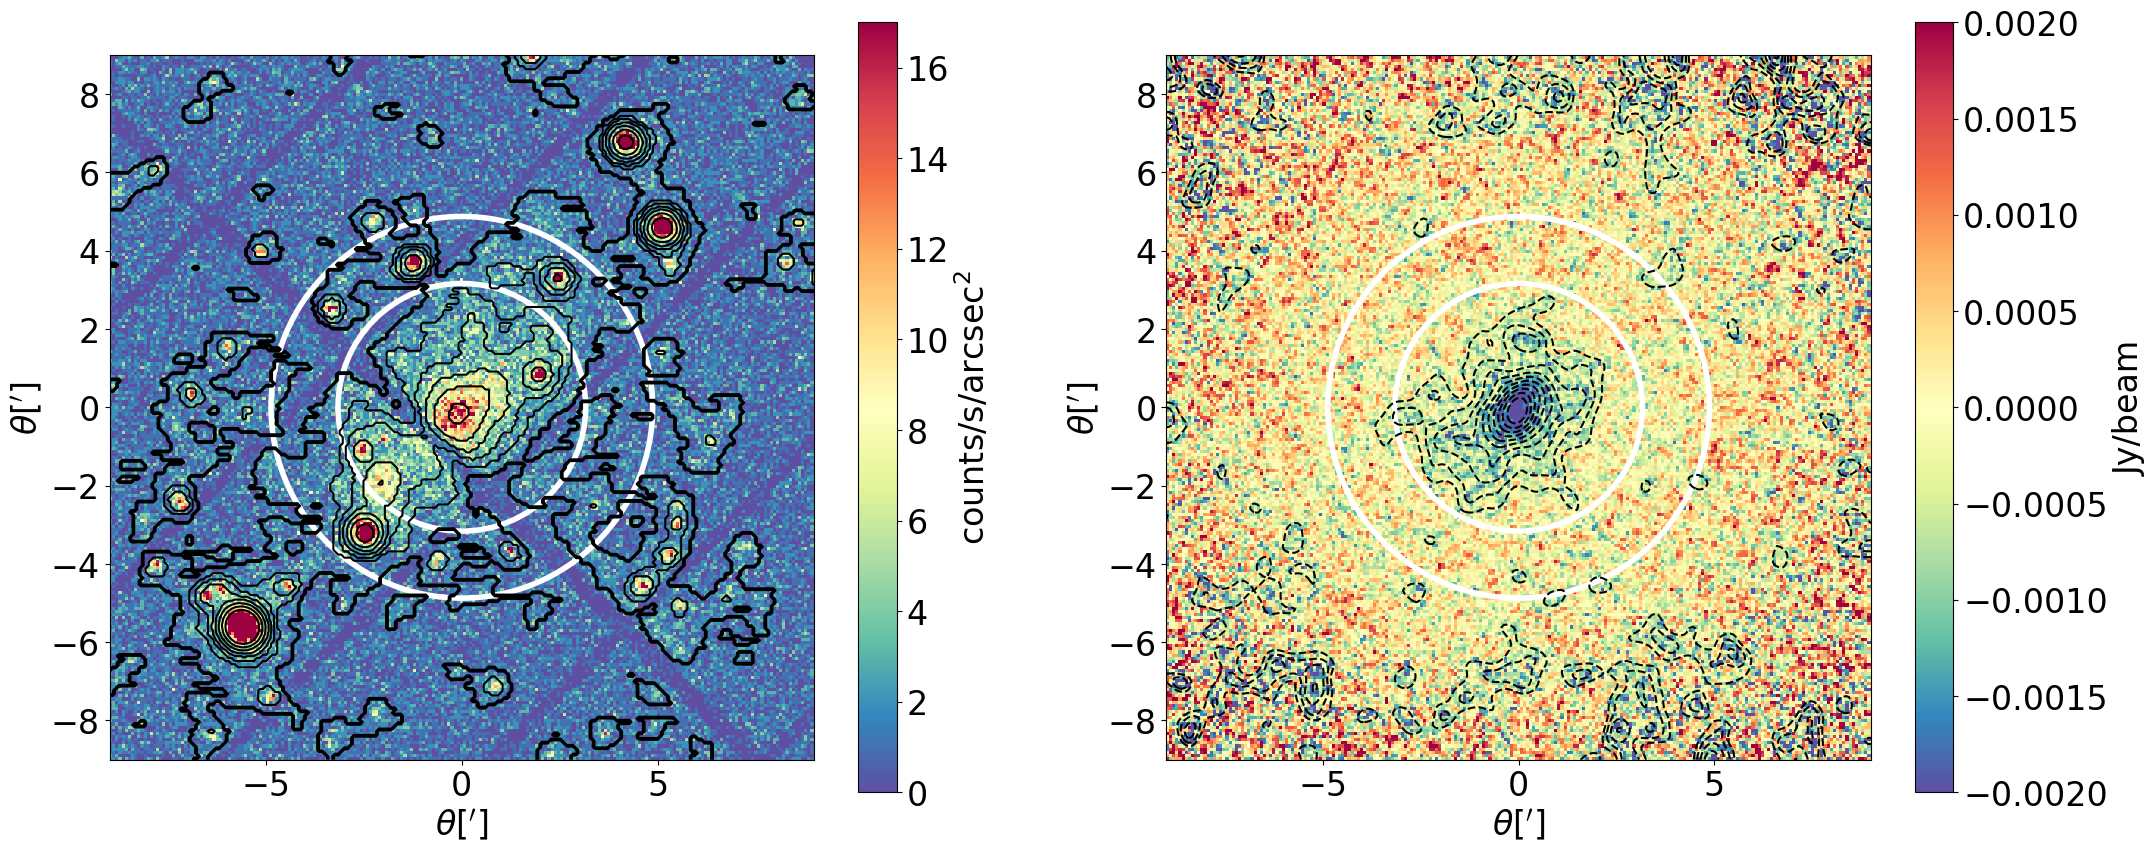

In [73]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(121, aspect='equal')
cropped_Xray_map = ax.pcolormesh(x, y, cropped_Xray, cmap='Spectral_r', vmin=vmin, vmax=vmax)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax.contour(x,y, gaussf(cropped_Xray,NIKA2_resolution), levels = levels, colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
plt.colorbar(cropped_Xray_map, label='counts/s/arcsec$^2$')

ax1 = fig.add_subplot(122, aspect='equal')
resamp_SZ_map = ax1.pcolormesh(x, y, resampled_SZ, cmap='Spectral_r', vmin=-0.002, vmax=0.002)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax1.contour(x,y, gaussf(resampled_SZ,NIKA2_resolution), levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)
ax1.add_artist(circle_r500)
ax1.add_artist(circle_r200)
ax1.set_xlabel(r"$\theta [']$")
ax1.set_ylabel(r"$\theta [']$")
plt.colorbar(resamp_SZ_map, label='Jy/beam')

plt.savefig(f'{plot_dir}/mock_resampled_cropped_CL{clust_number:04d}.png')

/tmp/ipykernel_953975/3412366803.py:9: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_953975/3412366803.py:20: UserWarning: The following kwargs were not used by contour: 'lw'
  ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)


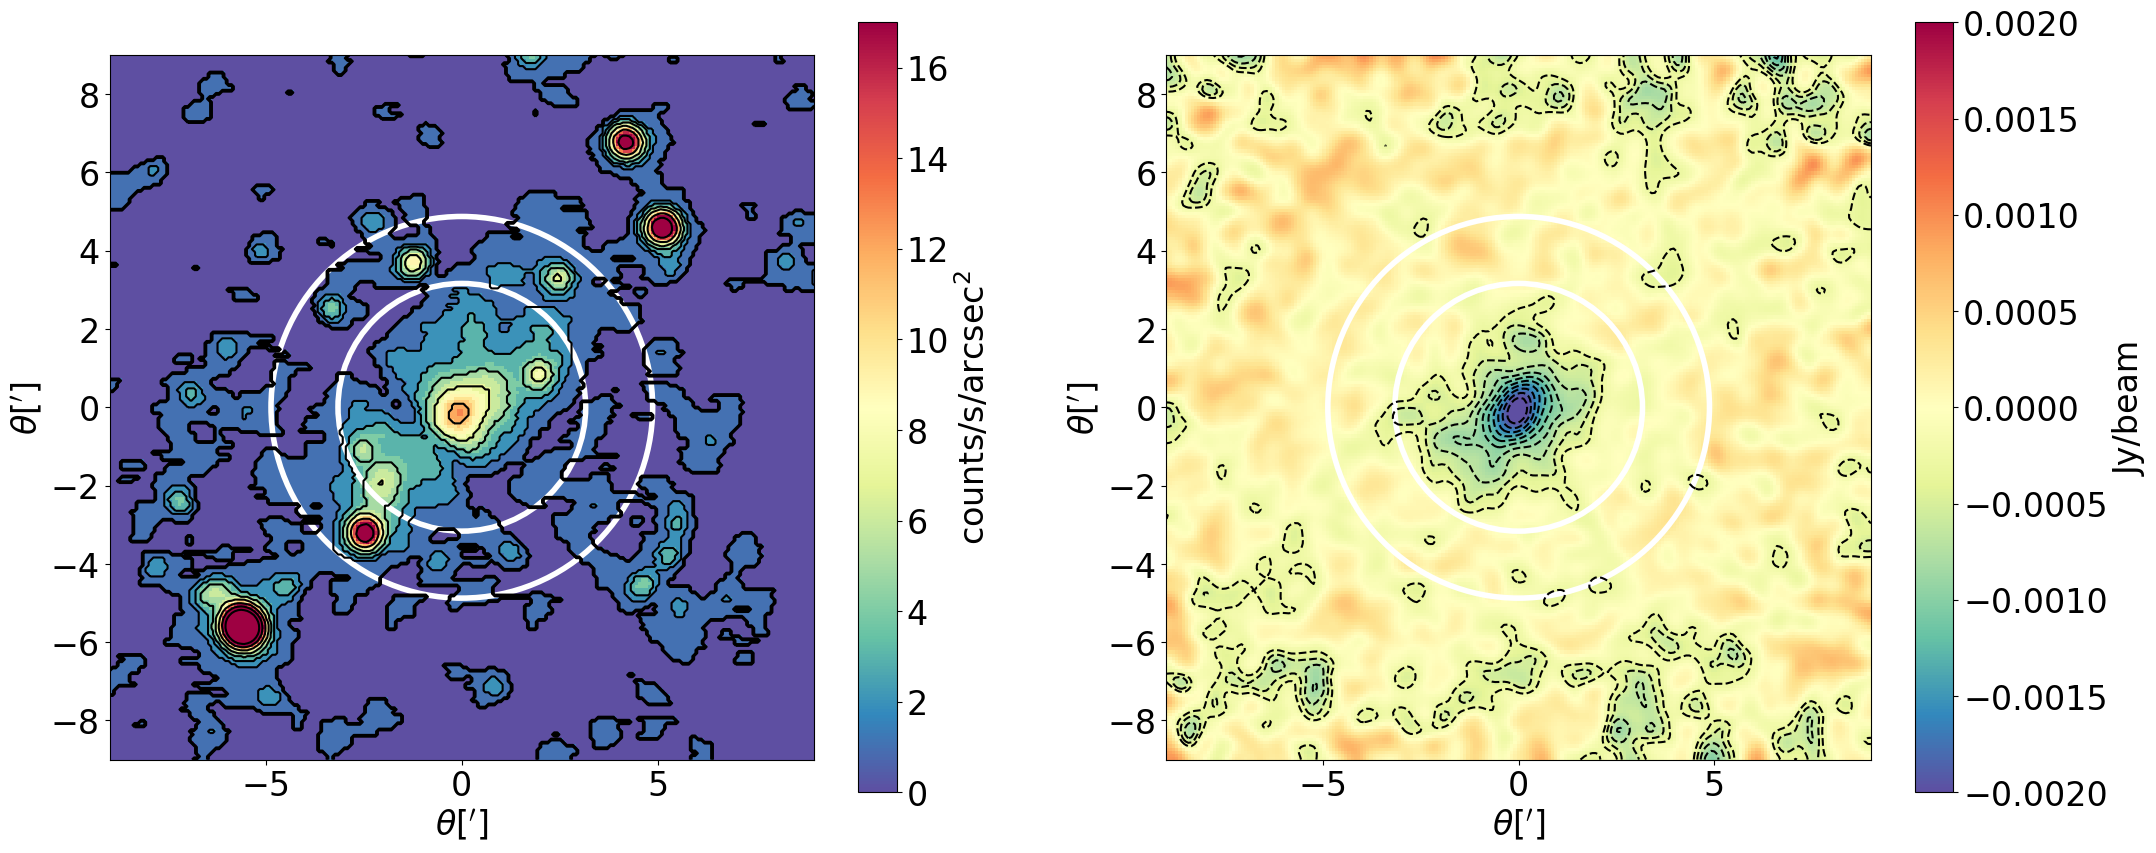

In [74]:
NIKA2_res_Xray = gaussf(cropped_Xray,NIKA2_resolution)
NIKA2_res_SZ = gaussf(resampled_SZ,NIKA2_resolution)

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(121, aspect='equal')
cropped_Xray_map = ax.pcolormesh(x, y, NIKA2_res_Xray, cmap='Spectral_r', vmin=vmin, vmax=vmax)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
plt.colorbar(cropped_Xray_map, label='counts/s/arcsec$^2$')

ax1 = fig.add_subplot(122, aspect='equal')
resamp_SZ_map = ax1.pcolormesh(x, y, NIKA2_res_SZ, cmap='Spectral_r', vmin=-0.002, vmax=0.002)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)
ax1.add_artist(circle_r500)
ax1.add_artist(circle_r200)
ax1.set_xlabel(r"$\theta [']$")
ax1.set_ylabel(r"$\theta [']$")
plt.colorbar(resamp_SZ_map, label='Jy/beam')

plt.savefig(f'{plot_dir}/mock_resampled_cropped_CL{clust_number:04d}_NIKA2_res.png')

In [75]:
print(pix_size_Xray)

0.00120833333333333


# Process $l_{eff}$ maps

In [76]:
ne_cube = np.load(f'/data7/NIKA2-300th/rwicker/Weiguang_sph_tests/CL{clust_number:04d}_snap{snap_number:03d}_sph_smoothed_ne_map_4r200.npy')
leff_pix_size_kp = 10
X_ray_pix_size_kp = Planck18.kpc_proper_per_arcmin(z).value*pix_size_Xray*60
print(X_ray_pix_size_kp)
X_leff_pix_ratio = leff_pix_size_kp/X_ray_pix_size_kp
print(X_leff_pix_ratio)
leff_map = (np.sum(ne_cube, axis=2)*leff_pix_size_kp)**2/(np.sum(ne_cube**2, axis=2)*leff_pix_size_kp)

np.save(f'/data7/NIKA2-300th/rwicker/Weiguang_sph_tests/true_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy', leff_map)

test_leff = plt.pcolormesh(leff_map, cmap='Spectral_r')
plt.colorbar(test_leff)

(422, 422)


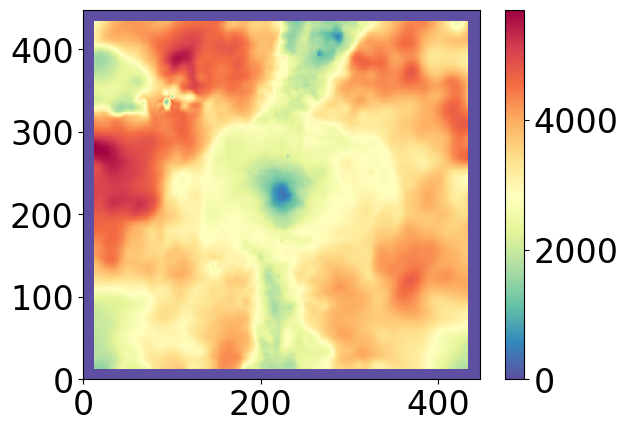

In [ ]:
resized_leff_map = resize(leff_map, (round(len(leff_map)*X_leff_pix_ratio),round(len(leff_map)*X_leff_pix_ratio)), order=1)
print(resized_leff_map.shape)
if len(resized_leff_map) < len(resampled_SZ):
    frame = np.zeros((len(resampled_SZ), len(resampled_SZ)))
    start = len(resampled_SZ)//2 - len(resized_leff_map)//2
    frame[start:start+len(resized_leff_map),start:start+len(resized_leff_map)] = resized_leff_map
    resized_leff_map = frame
test_leff = plt.pcolormesh(resized_leff_map, cmap='Spectral_r')
plt.colorbar(test_leff)

0 448


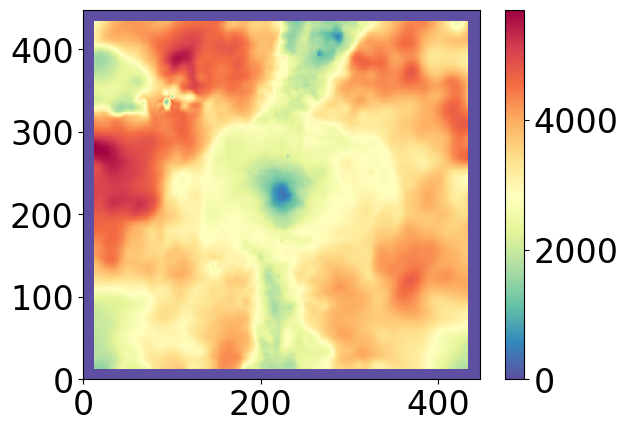

In [ ]:
lower_cropping_lim_leff = len(resized_leff_map)//2 - len(resampled_SZ)//2
upper_cropping_lim_leff = len(resized_leff_map)//2 + len(resampled_SZ)//2

cropped_leff = resized_leff_map[lower_cropping_lim_leff:upper_cropping_lim_leff, lower_cropping_lim_leff:upper_cropping_lim_leff]

print(lower_cropping_lim_leff, upper_cropping_lim_leff)

test_leff = plt.pcolormesh(cropped_leff, cmap='Spectral_r')
plt.colorbar(test_leff)

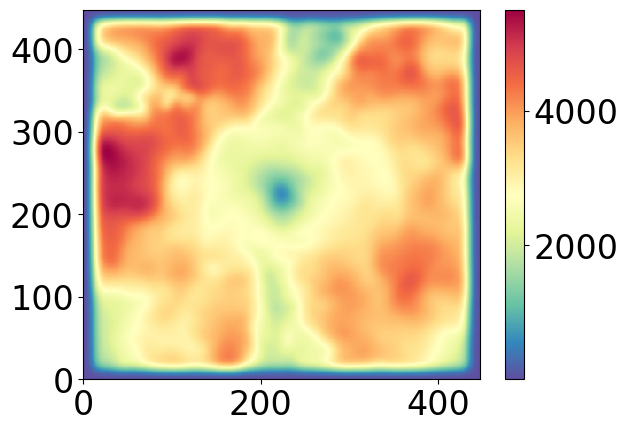

In [ ]:
leff_map_NIKA2_res = gaussf(cropped_leff, NIKA2_resolution)


test_leff = plt.pcolormesh(leff_map_NIKA2_res, cmap='Spectral_r')
plt.colorbar(test_leff)

/tmp/ipykernel_357901/263514993.py:6: UserWarning: No contour levels were found within the data range.
  ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_357901/263514993.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_357901/263514993.py:18: UserWarning: The following kwargs were not used by contour: 'lw'
  ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)


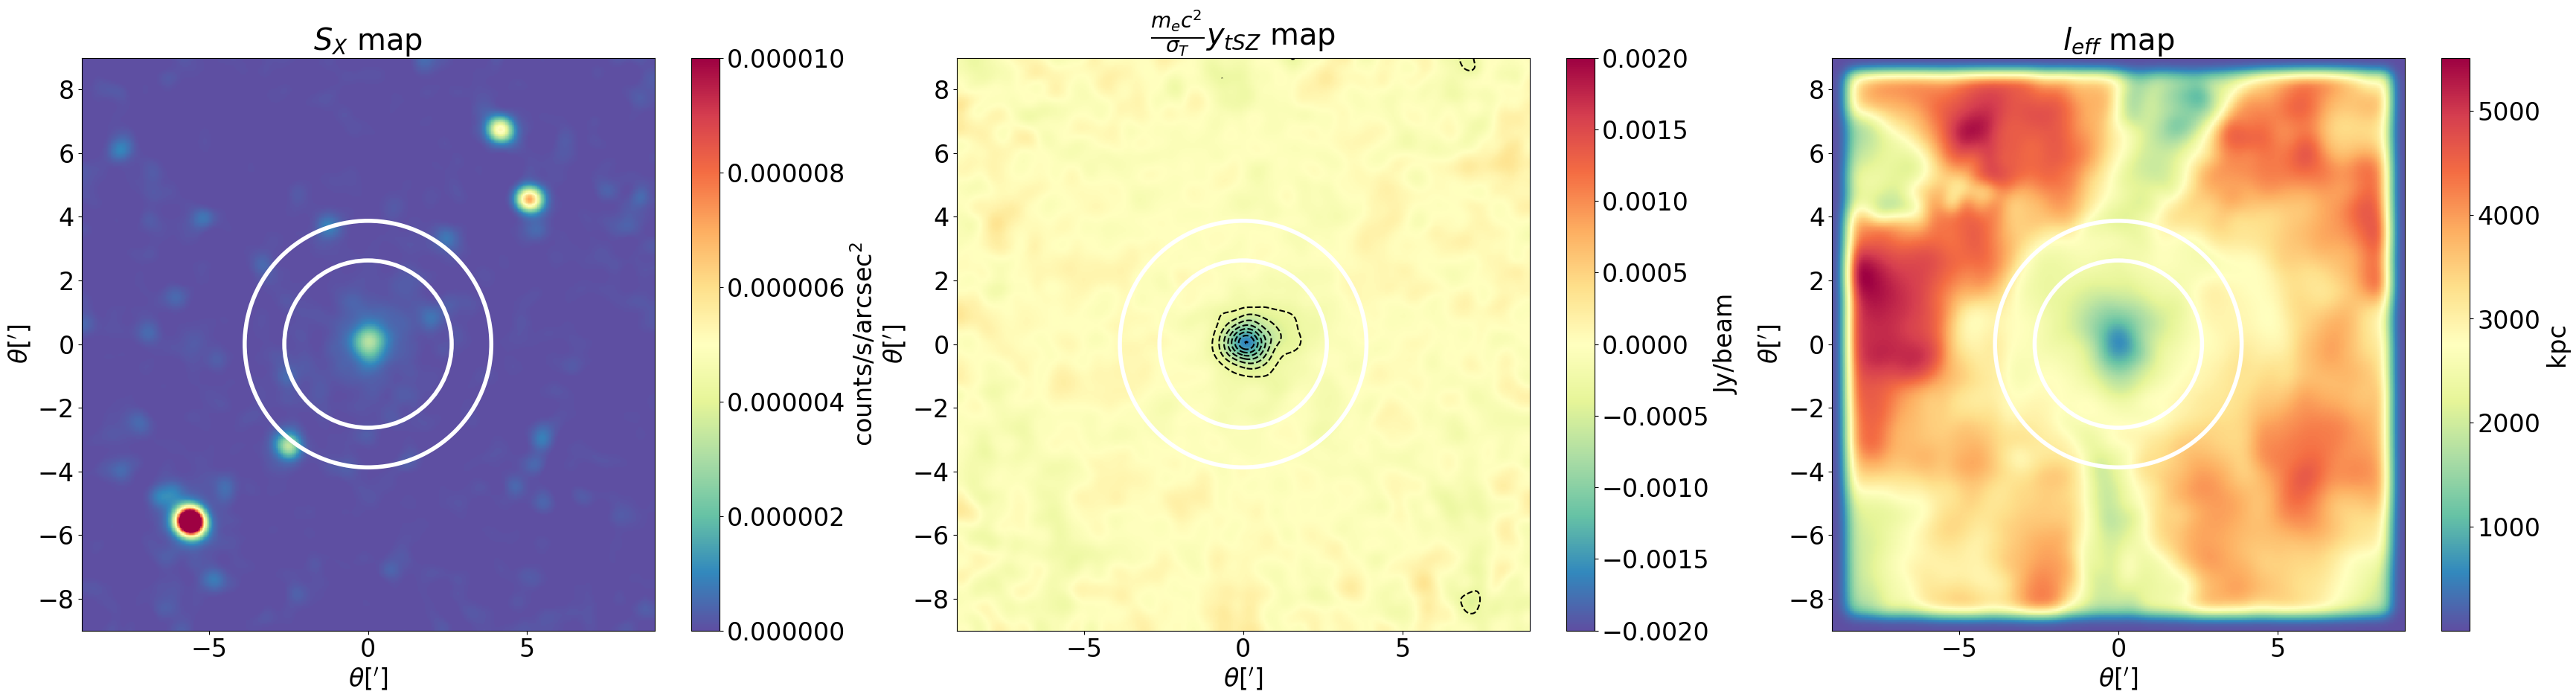

In [ ]:
fig = plt.figure(figsize=(43,10))
ax = fig.add_subplot(131, aspect='equal')
cropped_Xray_map = ax.pcolormesh(x, y, NIKA2_res_Xray, cmap='Spectral_r', vmin=vmin, vmax=vmax)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_title('$S_X$ map')
plt.colorbar(cropped_Xray_map, label='counts/s/arcsec$^2$')

ax1 = fig.add_subplot(132, aspect='equal')
resamp_SZ_map = ax1.pcolormesh(x, y, NIKA2_res_SZ, cmap='Spectral_r', vmin=-0.002, vmax=0.002)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)
ax1.add_artist(circle_r500)
ax1.add_artist(circle_r200)
ax1.set_xlabel(r"$\theta [']$")
ax1.set_ylabel(r"$\theta [']$")
ax1.set_title(r'$\frac{m_ec^2}{\sigma_T} y_{tSZ}$ map')
plt.colorbar(resamp_SZ_map, label='Jy/beam')

ax2 = fig.add_subplot(133, aspect='equal')
final_leff_map = ax2.pcolormesh(x, y, leff_map_NIKA2_res, cmap='Spectral_r')
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
#ax2.contour(x,y, leff_map_NIKA2_res, levels = np.linspace(1000, 7000, 15), colors='k', lw=2)
ax2.add_artist(circle_r500)
ax2.add_artist(circle_r200)
ax2.set_xlabel(r"$\theta [']$")
ax2.set_ylabel(r"$\theta [']$")
ax2.set_title(r'$l_{eff}$ map')
plt.colorbar(final_leff_map, label='kpc')

plt.savefig(f'{plot_dir}/all_necessary_maps_CL{clust_number:04d}_NIKA2_res.png')

# Process synthetic $l_{eff}$ map

15.058420908070584
0.6640802552305125


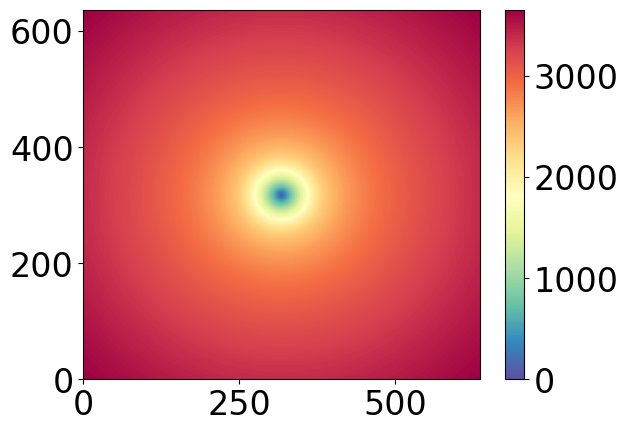

In [ ]:
synthetic_leff = np.load(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/synthetic_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
leff_pix_size_kp = 10
X_ray_pix_size_kp = Planck18.kpc_proper_per_arcmin(z).value*pix_size_Xray*60
print(X_ray_pix_size_kp)
X_leff_pix_ratio = leff_pix_size_kp/X_ray_pix_size_kp
print(X_leff_pix_ratio)

synthetic_leff_map = plt.pcolormesh(synthetic_leff, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

(423, 423)


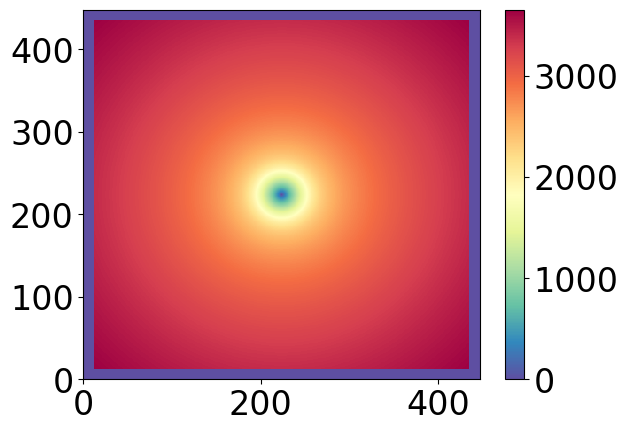

In [ ]:
resized_synthetic_leff_map = resize(synthetic_leff, (round(len(synthetic_leff)*X_leff_pix_ratio),round(len(synthetic_leff)*X_leff_pix_ratio)), order=1)
print(resized_synthetic_leff_map.shape)
if len(resized_synthetic_leff_map) < len(resampled_SZ):
    frame = np.zeros((len(resampled_SZ), len(resampled_SZ)))
    start = len(resampled_SZ)//2 - len(resized_synthetic_leff_map)//2
    frame[start:start+len(resized_synthetic_leff_map),start:start+len(resized_synthetic_leff_map)] = resized_synthetic_leff_map
    resized_synthetic_leff_map = frame
synthetic_leff_map = plt.pcolormesh(resized_synthetic_leff_map, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

0 448


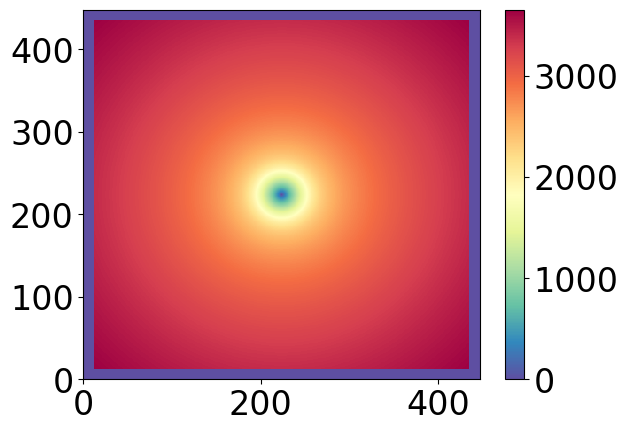

In [ ]:
lower_cropping_lim_synth_leff = len(resized_synthetic_leff_map)//2 - len(resampled_SZ)//2
upper_cropping_lim_synth_leff = len(resized_synthetic_leff_map)//2 + len(resampled_SZ)//2

cropped_synthetic_leff = resized_synthetic_leff_map[lower_cropping_lim_synth_leff:upper_cropping_lim_synth_leff, lower_cropping_lim_synth_leff:upper_cropping_lim_synth_leff]

print(lower_cropping_lim_synth_leff, upper_cropping_lim_synth_leff)

synthetic_leff_map = plt.pcolormesh(cropped_synthetic_leff, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

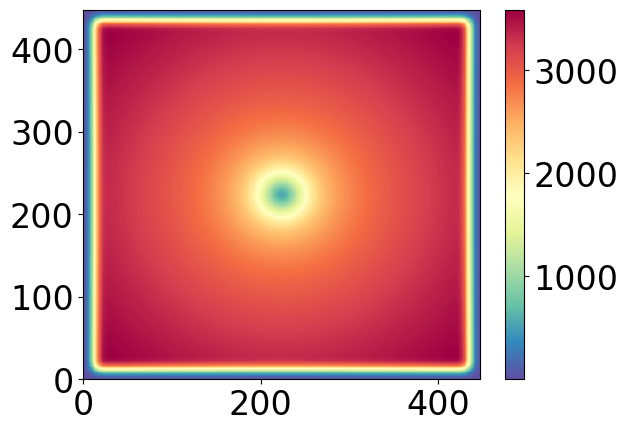

In [ ]:
synth_leff_map_NIKA2_res = gaussf(cropped_synthetic_leff, NIKA2_resolution)


synthetic_leff_map = plt.pcolormesh(synth_leff_map_NIKA2_res, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

/tmp/ipykernel_357901/3458883302.py:6: UserWarning: No contour levels were found within the data range.
  ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_357901/3458883302.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
/tmp/ipykernel_357901/3458883302.py:22: UserWarning: The following kwargs were not used by contour: 'lw'
  ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)


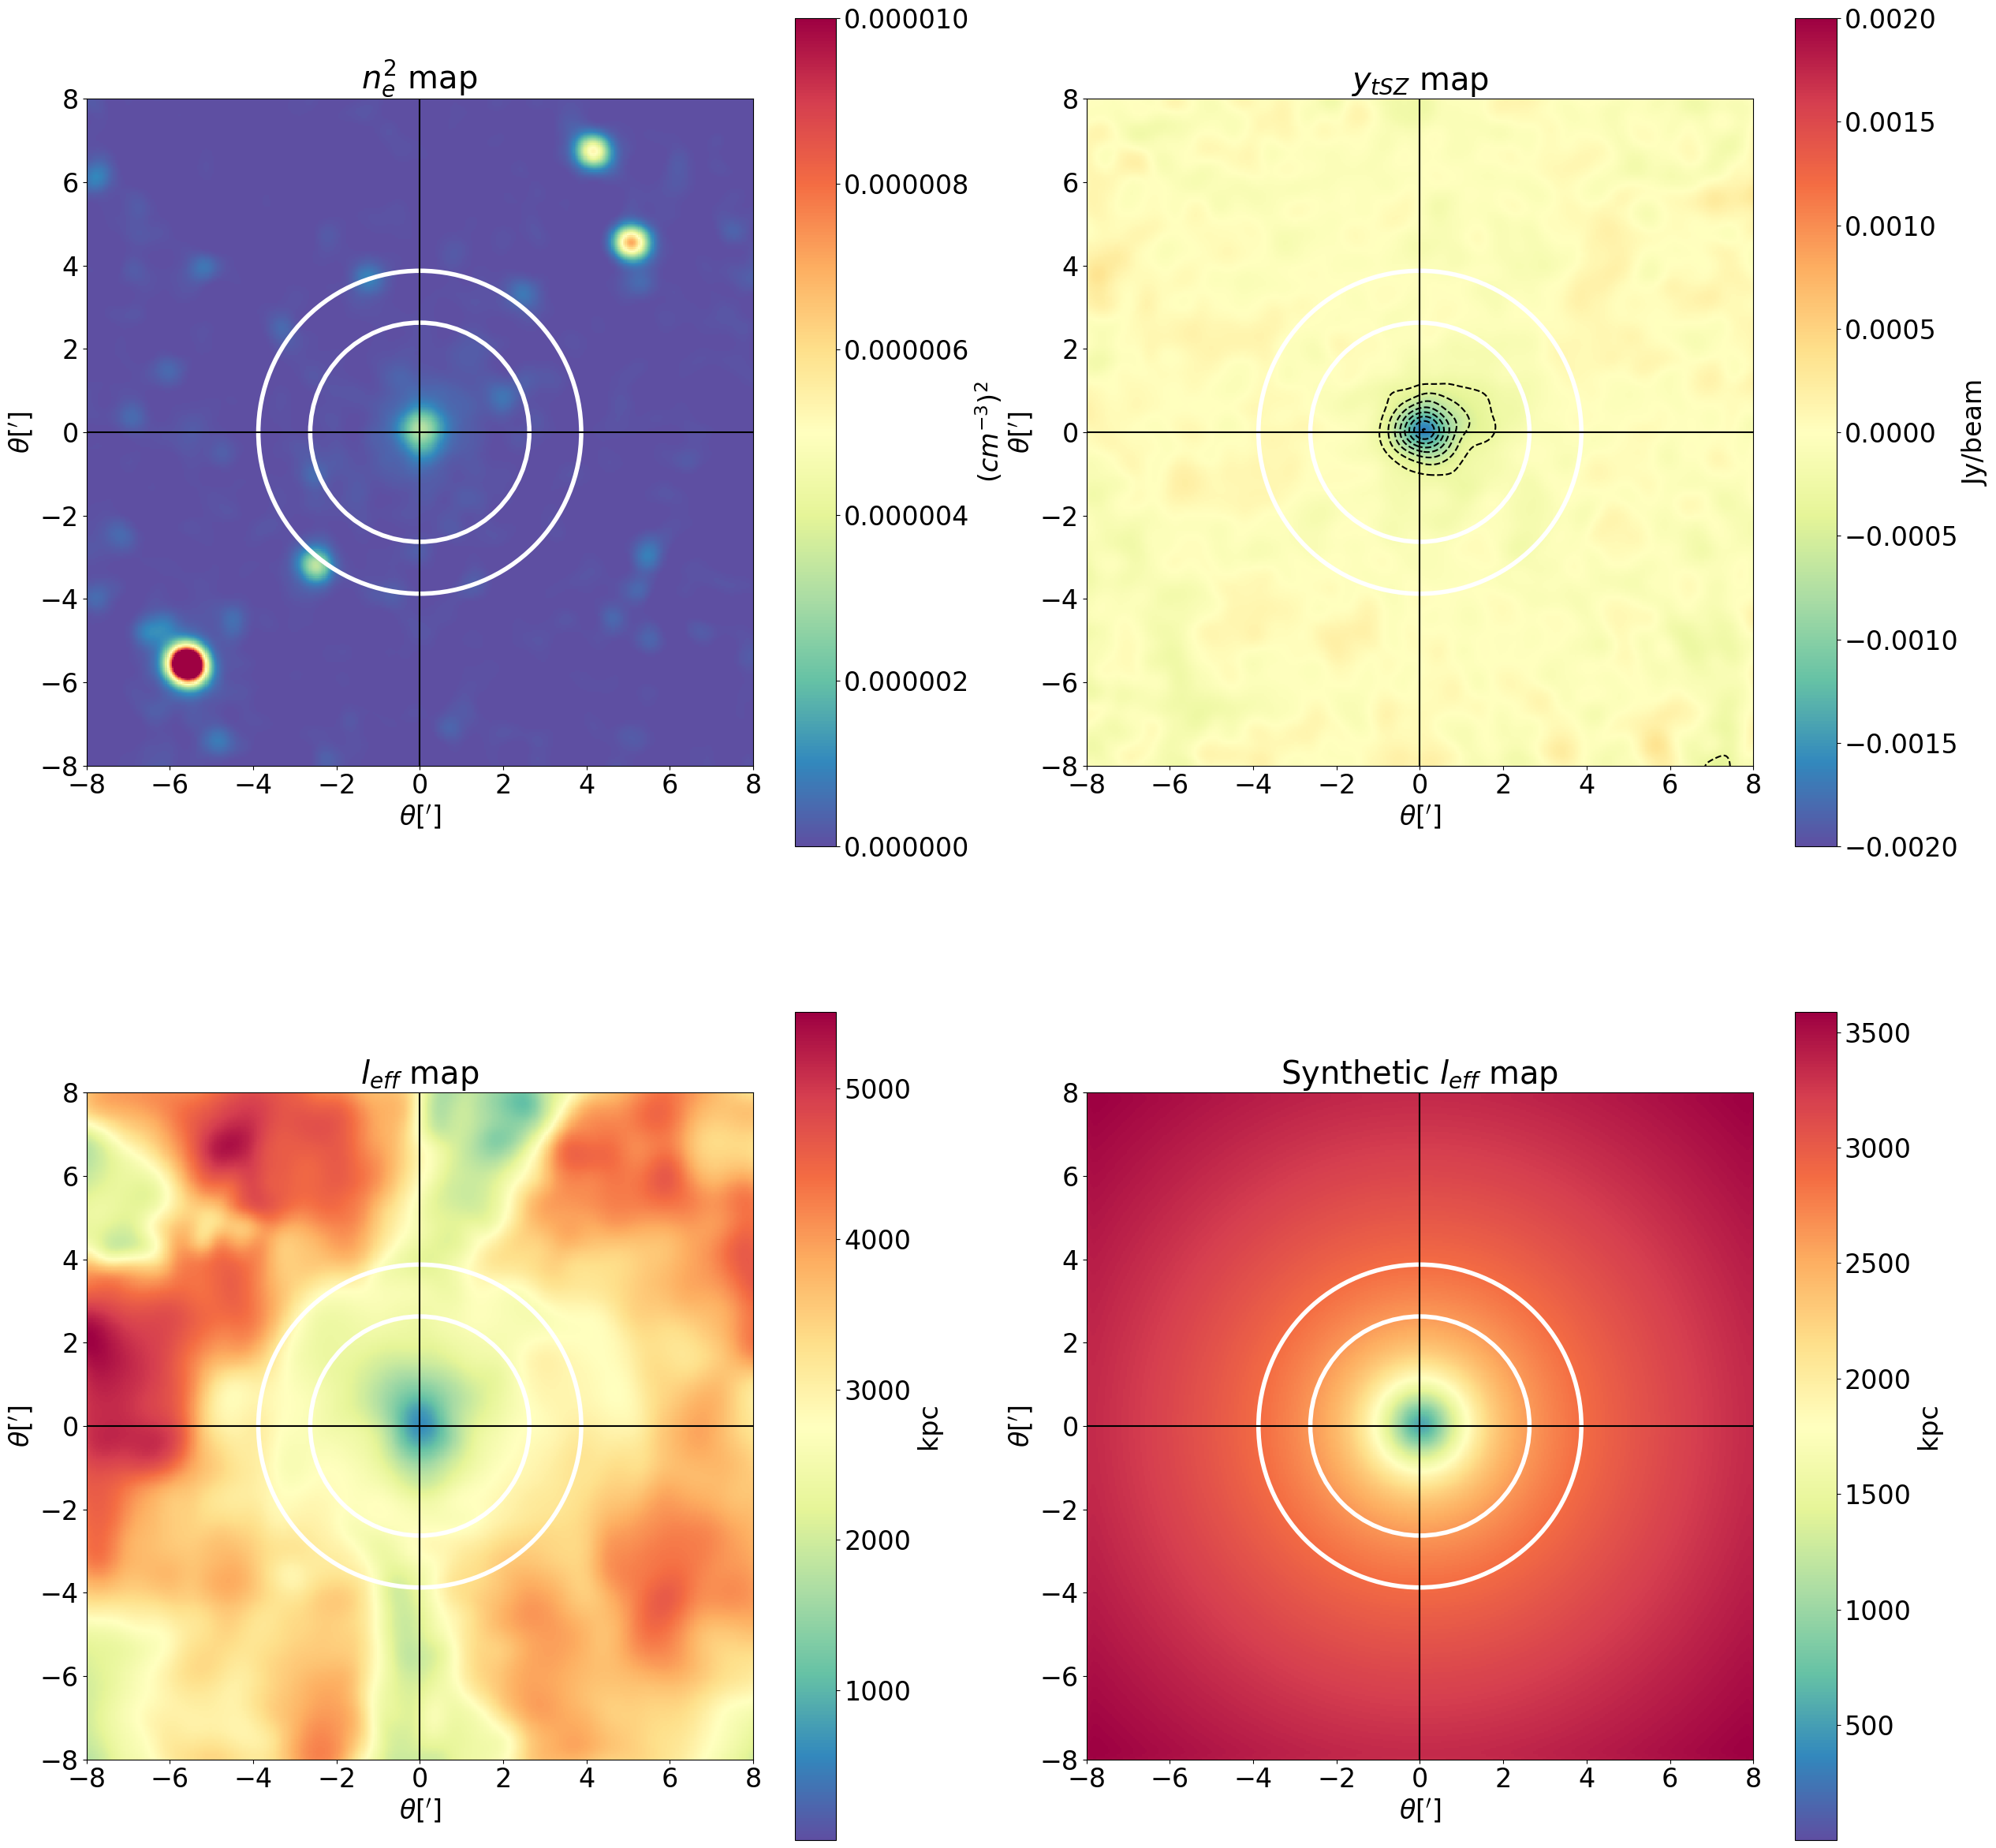

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(221, aspect='equal')
cropped_Xray_map = ax.pcolormesh(x, y, NIKA2_res_Xray, cmap='Spectral_r', vmin=vmin, vmax=vmax)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax.contour(x,y, NIKA2_res_Xray, levels = levels, colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_title('$n_e^2$ map')
ax.hlines(0., -10, 10)
ax.vlines(0., -10, 10)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
plt.colorbar(cropped_Xray_map, label='$(cm^{-3})^2$')

ax1 = fig.add_subplot(222, aspect='equal')
resamp_SZ_map = ax1.pcolormesh(x, y, NIKA2_res_SZ, cmap='Spectral_r', vmin=-0.002, vmax=0.002)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
ax1.contour(x,y, NIKA2_res_SZ, levels = np.linspace(-0.002, -0.0003, 10), colors='k', lw=2)
ax1.add_artist(circle_r500)
ax1.add_artist(circle_r200)
ax1.set_xlabel(r"$\theta [']$")
ax1.set_ylabel(r"$\theta [']$")
ax1.set_title(r'$y_{tSZ}$ map')
ax1.hlines(0., -10, 10)
ax1.vlines(0., -10, 10)
ax1.set_xlim(-8, 8)
ax1.set_ylim(-8, 8)
plt.colorbar(resamp_SZ_map, label='Jy/beam')

ax2 = fig.add_subplot(223, aspect='equal')
final_leff_map = ax2.pcolormesh(x, y, leff_map_NIKA2_res, cmap='Spectral_r')
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
#ax2.contour(x,y, leff_map_NIKA2_res, levels = np.linspace(1000, 7000, 15), colors='k', lw=2)
ax2.add_artist(circle_r500)
ax2.add_artist(circle_r200)
ax2.set_xlabel(r"$\theta [']$")
ax2.set_ylabel(r"$\theta [']$")
ax2.set_title(r'$l_{eff}$ map')
ax2.hlines(0., -10, 10)
ax2.vlines(0., -10, 10)
ax2.set_xlim(-8, 8)
ax2.set_ylim(-8, 8)
plt.colorbar(final_leff_map, label='kpc')

ax3 = fig.add_subplot(224, aspect='equal')
final_leff_map = ax3.pcolormesh(x, y, synth_leff_map_NIKA2_res, cmap='Spectral_r')
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='w')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='w')
#ax2.contour(x,y, leff_map_NIKA2_res, levels = np.linspace(1000, 7000, 15), colors='k', lw=2)
ax3.add_artist(circle_r500)
ax3.add_artist(circle_r200)
ax3.set_xlabel(r"$\theta [']$")
ax3.set_ylabel(r"$\theta [']$")
ax3.set_title(r'Synthetic $l_{eff}$ map')
ax3.hlines(0., -10, 10)
ax3.vlines(0., -10, 10)
ax3.set_xlim(-8, 8)
ax3.set_ylim(-8, 8)
plt.colorbar(final_leff_map, label='kpc')

plt.savefig(f'{plot_dir}/all_necessary_maps_CL{clust_number:04d}_NIKA2_res.png')

# Produce T maps (with true and synthetic $l_{eff}$)

/tmp/ipykernel_357901/2721095202.py:7: RuntimeWarning: invalid value encountered in sqrt
  effective_density = np.sqrt(converted_Xray/converted_leff)


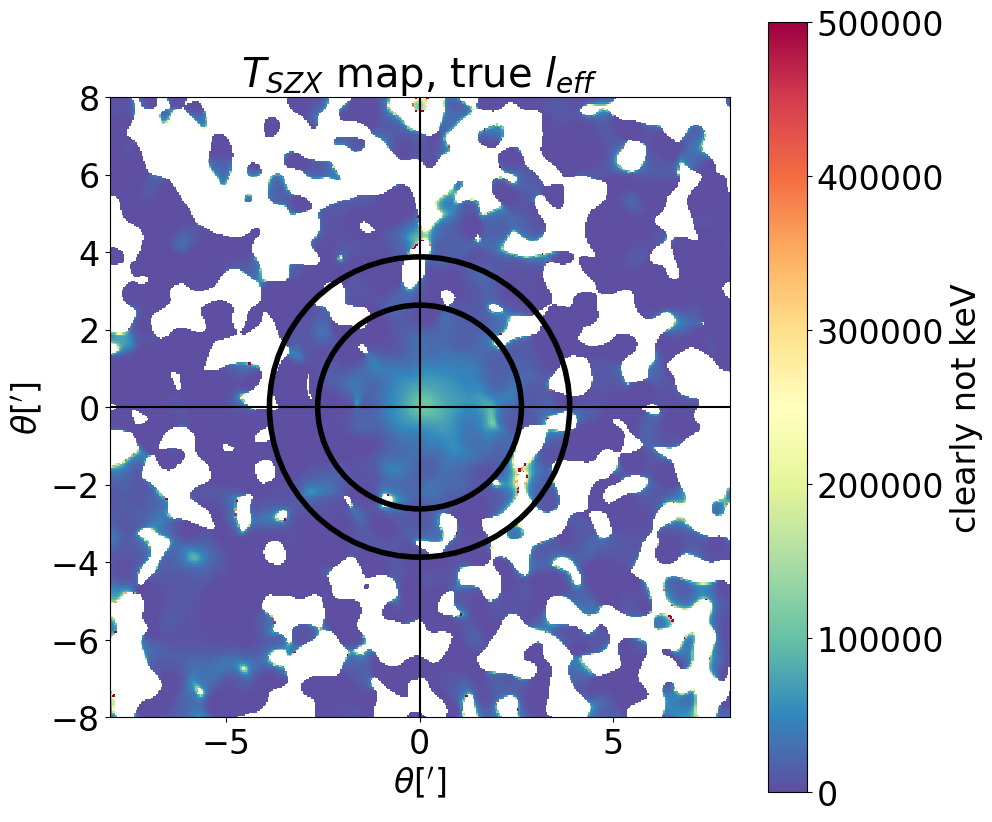

In [ ]:
converted_SZ = NIKA2_res_SZ * (-11.9)
converted_leff = leff_map_NIKA2_res*(3.086e21)
mec2_sigmat = 511/6.65245873e-25
converted_Xray = NIKA2_res_Xray*(3.086e21)
converted_synthetic_leff = synth_leff_map_NIKA2_res

effective_density = np.sqrt(converted_Xray/converted_leff)
effective_pressure = mec2_sigmat * converted_SZ/converted_leff

tentative_T = effective_pressure/effective_density


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect='equal')
first_Tmap = ax.pcolormesh(x, y, tentative_T, cmap='Spectral_r', vmin=0, vmax=5e5)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='k')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='k')
#ax.contour(x,y, NIKA2_res_Xray, levels = np.logspace(0., 1.5, 10), colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_title('$T_{SZX}$ map, true $l_{eff}$')
ax.hlines(0., -10, 10)
ax.vlines(0., -10, 10)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
plt.colorbar(first_Tmap, label='clearly not keV')

plt.savefig(f'{plot_dir}/first_mock_Tmap_CL{clust_number:04d}.png')

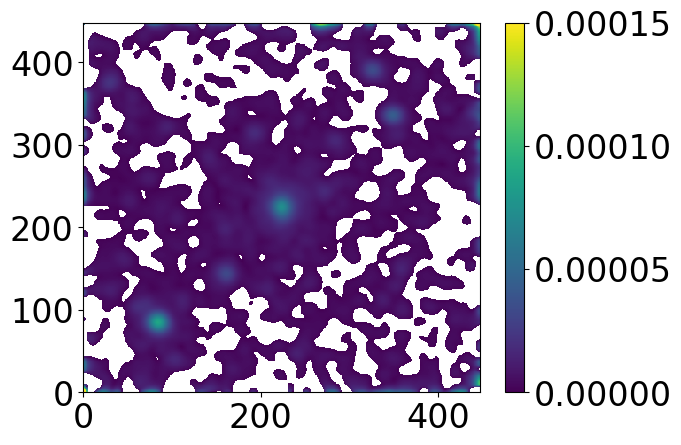

In [ ]:
eff_dens_map = plt.pcolormesh(effective_density, vmin=0., vmax=1.5e-4)
plt.colorbar(eff_dens_map)

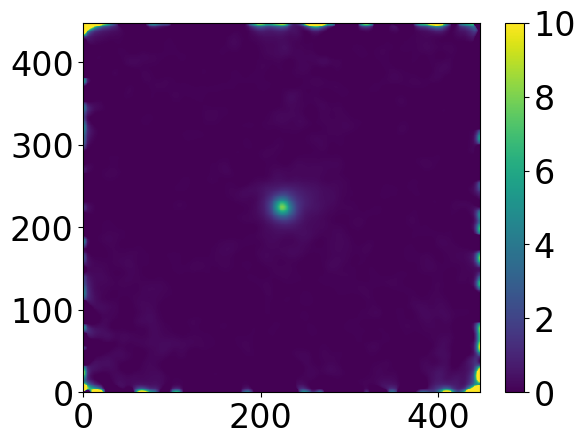

In [ ]:
eff_press_map = plt.pcolormesh(effective_pressure, vmin=0, vmax=10)
plt.colorbar(eff_press_map)

/tmp/ipykernel_357901/2488051427.py:1: RuntimeWarning: invalid value encountered in sqrt
  tentative_T_synth_leff = 1/np.sqrt(converted_synthetic_leff) * mec2_sigmat * converted_SZ * np.sqrt(1/(4*np.pi*(1+z)**4*converted_Xray))


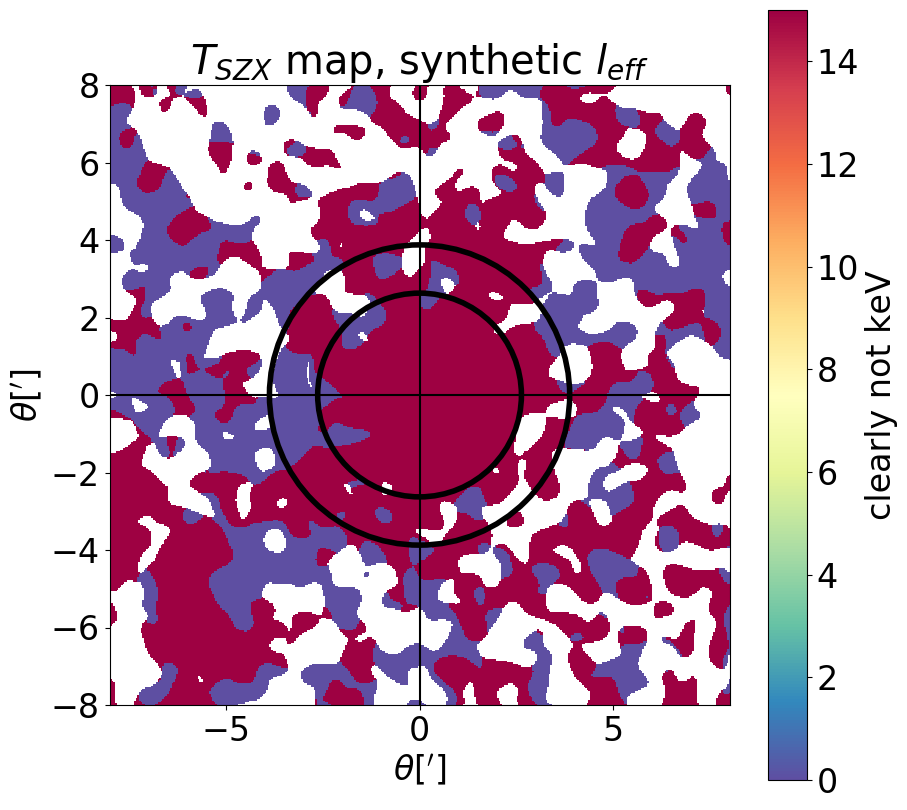

In [ ]:
tentative_T_synth_leff = 1/np.sqrt(converted_synthetic_leff) * mec2_sigmat * converted_SZ * np.sqrt(1/(4*np.pi*(1+z)**4*converted_Xray))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect='equal')
first_Tmap_synth_leff = ax.pcolormesh(x, y, tentative_T_synth_leff, cmap='Spectral_r', vmin=0, vmax=15)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='k')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='k')
#ax.contour(x,y, NIKA2_res_Xray, levels = np.logspace(0., 1.5, 10), colors='k', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_title('$T_{SZX}$ map, synthetic $l_{eff}$')
ax.hlines(0., -10, 10)
ax.vlines(0., -10, 10)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
plt.colorbar(first_Tmap_synth_leff, label='clearly not keV')

plt.savefig(f'{plot_dir}/first_mock_Tmap_CL{clust_number:04d}_synth_leff.png')

/tmp/ipykernel_357901/3933255462.py:8: UserWarning: No contour levels were found within the data range.
  ax.contour(x,y, true_v_synth_leff_Tcomparison, levels = np.linspace(-0.1, 0.1, 10), cmap='seismic', lw=0.1)
/tmp/ipykernel_357901/3933255462.py:8: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(x,y, true_v_synth_leff_Tcomparison, levels = np.linspace(-0.1, 0.1, 10), cmap='seismic', lw=0.1)


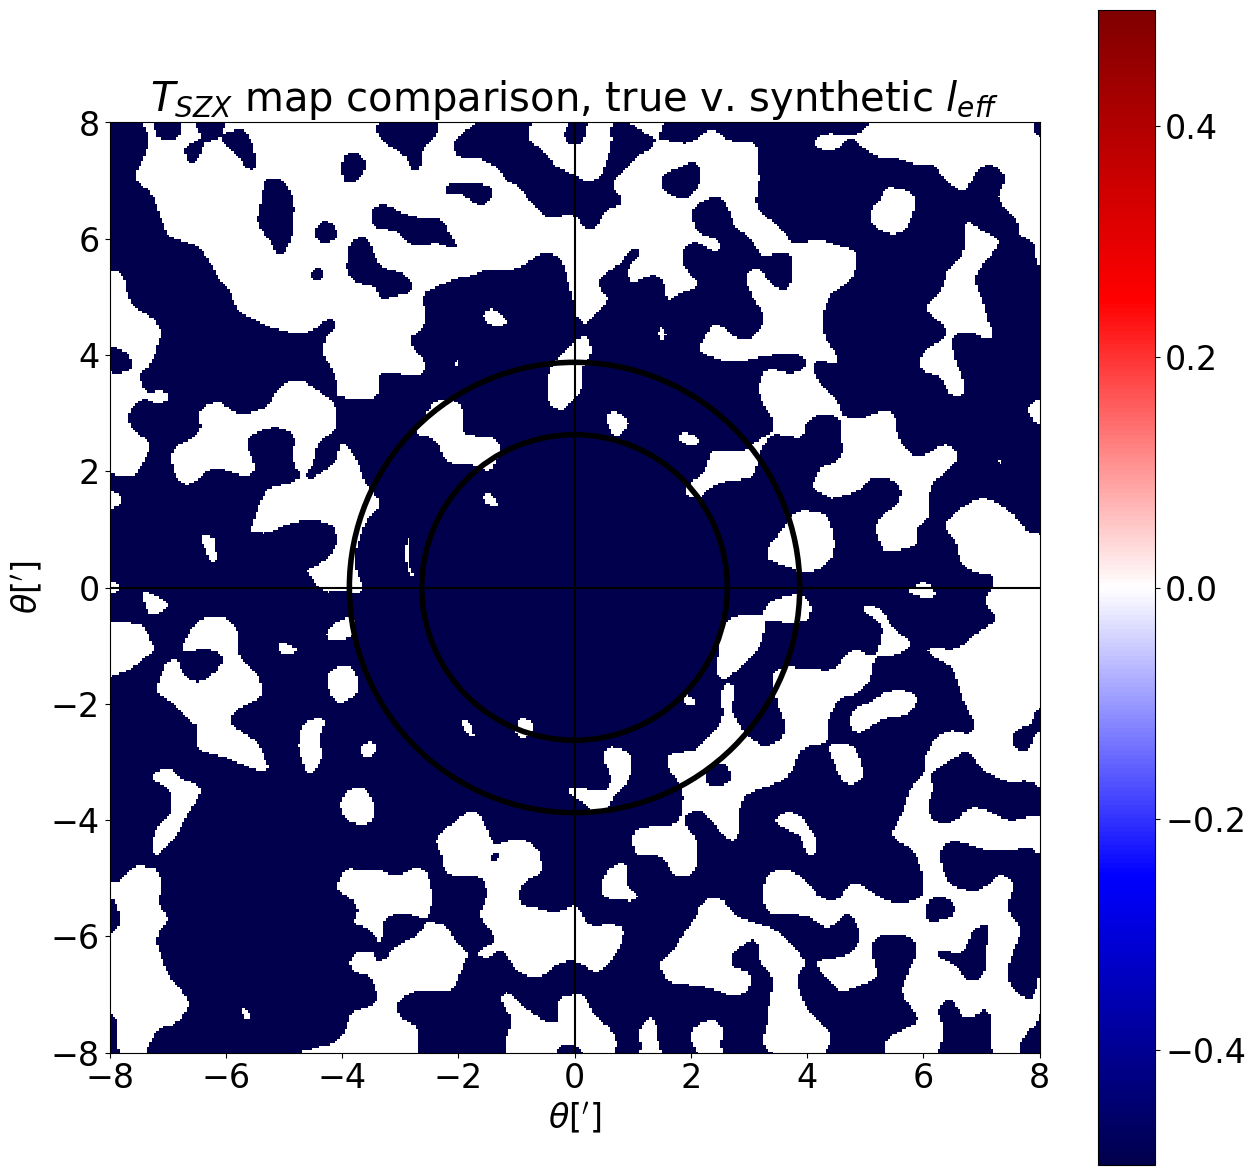

In [ ]:
true_v_synth_leff_Tcomparison = (tentative_T - tentative_T_synth_leff)/tentative_T

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, aspect='equal')
temp_comparison = ax.pcolormesh(x, y, true_v_synth_leff_Tcomparison, cmap='seismic', vmin=-0.5, vmax=0.5)
circle_r500 = plt.Circle((0., 0.), r500_arcmin, fill=False, lw=4, color='k')
circle_r200 = plt.Circle((0., 0.), r200_arcmin, fill=False, lw=4, color='k')
ax.contour(x,y, true_v_synth_leff_Tcomparison, levels = np.linspace(-0.1, 0.1, 10), cmap='seismic', lw=0.1)
ax.add_artist(circle_r500)
ax.add_artist(circle_r200)
ax.set_xlabel(r"$\theta [']$")
ax.set_ylabel(r"$\theta [']$")
ax.set_title('$T_{SZX}$ map comparison, true v. synthetic $l_{eff}$')
ax.hlines(0., -10, 10)
ax.vlines(0., -10, 10)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
plt.colorbar(temp_comparison)

plt.savefig(f'{plot_dir}/Tmap_comparison_CL{clust_number:04d}_true_v_synth_leff.png')

# Comparing between different types of $l_{eff}$ maps :
* True $l_{eff}$
* Synthetic $l_{eff}$ from the "generalised high-pass filter" model
* Synthetic $l_{eff}$ generated from a $\beta$ density profile

### First, process the $\beta-n_e$ inferred $l_{eff}$ map

In [ ]:
synthetic_beta_leff = np.load(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/beta_ne_synth_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
beta_leff_pix_size_kp = 10
X_ray_pix_size_kp = Planck18.kpc_proper_per_arcmin(z).value*pix_size_Xray*60
X_beta_leff_pix_ratio = beta_leff_pix_size_kp/X_ray_pix_size_kp

resized_synthetic_beta_leff_map = resize(synthetic_beta_leff, (round(len(synthetic_beta_leff)*X_beta_leff_pix_ratio),round(len(synthetic_beta_leff)*X_beta_leff_pix_ratio)), order=1)
print(resized_synthetic_beta_leff_map.shape)
if len(resized_synthetic_beta_leff_map) < len(resampled_SZ):
    frame = np.zeros((len(resampled_SZ), len(resampled_SZ)))
    start = len(resampled_SZ)//2 - len(resized_synthetic_beta_leff_map)//2
    frame[start:start+len(resized_synthetic_beta_leff_map),start:start+len(resized_synthetic_beta_leff_map)] = resized_synthetic_beta_leff_map
    resized_synthetic_beta_leff_map = frame

lower_cropping_lim_synth_beta_leff = len(resized_synthetic_beta_leff_map)//2 - len(resampled_SZ)//2
upper_cropping_lim_synth_beta_leff = len(resized_synthetic_beta_leff_map)//2 + len(resampled_SZ)//2
cropped_synthetic_beta_leff = resized_synthetic_leff_map[lower_cropping_lim_synth_beta_leff:upper_cropping_lim_synth_beta_leff, lower_cropping_lim_synth_beta_leff:upper_cropping_lim_synth_beta_leff]

synth_beta_leff_map_NIKA2_res = gaussf(cropped_synthetic_beta_leff, NIKA2_resolution)

synthetic_beta_leff_map = plt.pcolormesh(synth_beta_leff_map_NIKA2_res, cmap='Spectral_r')
plt.colorbar(synthetic_beta_leff_map)